# Generation of the Faux data with Zemax PSFs

### Plan of attack:
1. Generate data with Zemax PSFs that perturbs the field angle, separation and contrast of Alpha Cen A and B
    - Note it is important to add some noise to these images to prevent the fitting algorithms from getting stuck
    - As a start point try simply adding read noise from the detector
2. Use a least squares fit from models generated with Fourier Transforms to fit these parameters
    - Don't forget to add a sensical termination point
3. See how much a perturbation in the faux data ($\Delta x_f$) translates to a a perturbation in the model ($\Delta x_r$)
    - We want $\Delta x_f = \alpha \Delta x_r$, ie linear
    - With linearity we can extract our science goal (we only need relative separation, not absolute)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from tqdm import tqdm

from lib.formatter import *
from lib.conversions import *
from lib.detector_modelling import *
from lib.FT_modelling import *
from lib.synphot import *

In [20]:
# Optical Architecture
aperture = 0.1 # m
central_obscuration = 0.011 # m, diameter
focal_length = 3.635 # m

# CCD Architecture
# detector_size = 2000
detector_size = 512
detector_pitch = 6.5e-6
fps = 7.5
QE = 0.9
read_noise = 1.6
dark_current = 0.68
gain = 1.29
full_well = 95e3

# Zemax settings
zmx_pixel_size = 1.625e-6

In [3]:
# Inputs for pysynphot
nwavels = 1001
wl_range = np.array([545e-9, 645e-9]) # Angstroms

In [4]:
# Stellar Parameters
acenA = {"mag":0.01, 
        "Teff":5790, 
        "Z": 0.2, 
        "log g": 4.30}

acenB = {"mag":1.33, 
        "Teff":5260, 
        "Z": 0.23, 
        "log g": 4.37}

In [5]:
# Create stellar observation object
acenA["obs"] = create_stellar_obs(aperture*100, central_obscuration*100, nwavels, wl_range*(10e9), acenA)
acenB["obs"] = create_stellar_obs(aperture*100, central_obscuration*100, nwavels, wl_range*(10e9), acenB)

# Uncomment this to get equal magnitudes (makes it easier to distinguish)
# acenB["obs"] = acenA["obs"]

# Calculate photon rate per second
acenA["rate/s"] = acenA["obs"].countrate() # Has units of counts per second
acenB["rate/s"] = acenB["obs"].countrate() # Has units of counts per second

# Caluate photon rate per frame
acenA["rate/frame"] = acenA["rate/s"]/fps
acenB["rate/frame"] = acenB["rate/s"]/fps

# Calculate the binary separation
acenA["coord"] = SkyCoord("14h39m36.49400s -60d50m02.3737s")
acenB["coord"] = SkyCoord("14h39m35.06311s -60d50m15.0992s")
binary_separation = acenA["coord"].separation(acenB["coord"]).arcsec

In [6]:
#Input the raw the psf from zemax
psf_on_norm_zmx, psf_on_meta_data_zmx = zemax_to_array('files/on-axis_broadband.txt')
psf_off_norm_zmx, psf_off_meta_data_zmx = zemax_to_array('files/off-axis_broadband.txt')

## Generation of faux science parameters
    - Field angle       --> A
    - Binary separation --> B
    - Realtive contrast --> C

---
### Field angle, A:
> We want to perturb this by ~ 1/2 a pixel. 
> 
> The pixel scale is ~0.375 arcseconds per pixels so we want a total perturbation of 0.1875. We need to convert this to a field angle.
>
> $\alpha$ Cen B orbits at a separation of ~16.5 arcsec. Using this as a radius the total orbit is $2\pi * 16.5 ~= 103.5$ arcseconds.
>
> The ratio of the total orbital length we want to perturb by is then $103.5/0.1875 = 1.812e-3$. 
>
> This gives us a total angular perturbation of $2\pi * 1.812e-3 = 0.0114$ or +- $5.7e-3$ radians.
>
> Spread over 5 positions this gives a $\Delta$A = $1.14e-3$ radians.
    

In [16]:
central = 0
delta_A = 1.14e-3 # radians
start = central - 2*delta_A
end = central + 2*delta_A
num = 5
field_angles = np.linspace(start, end, num=num, dtype=np.float64)

print(field_angles)

[-0.00228 -0.00114  0.       0.00114  0.00228]


---
### Binary separation, B:
> We want to perturb this in the micro-arcsecond regieme. For a start we will perturb linearly by +- 5 micro-arcseconds over 5 positions for a $\Delta$B = 2 $\mu$asec



In [17]:
# Acen A stays in the central FoV
acenA_pos = np.zeros(5)

# AcenB central point at 16.5 arcseconds
central = 16.5 # arcseconds
delta_B = 2e-6
start = central - 2*delta_B
end = central + 2*delta_B
num = 5
binary_separations = np.linspace(start, end, num=num, dtype=np.float64)

print(binary_separations)

[16.499996 16.499998 16.5      16.500002 16.500004]


---
### Relative contrast, C:
> For simplicity we will measure contrast as a ratio of count rates from each star
>
> We want a total relative contrast perturbation of ~ 5% over 5 positions for a $\Delta$C of 1%
>
> To shift the relative contrast by $\Delta C$ we want $A_{new} = A + \frac{A*\Delta C}{A/B}$ 


In [95]:
acenA_countrate = acenA["rate/frame"] 
acenB_countrate = acenB["rate/frame"]

delta_C = 0.01
start = - 2*delta_C
end = + 2*delta_C
num = 5
delta_Cs = np.linspace(start, end, num=num)

# Shift contrasts by changing the brightness of AcenA 
A = acenA_countrate
B = acenB_countrate
acenA_countrates_new = [A + (A*delta_C)/(A/B) for delta_C in delta_Cs]
ratio = A/B

print(ratio - np.array(acenA_countrates_new)/B)

[ 0.02  0.01  0.   -0.01 -0.02]



---
Using these perturbation parameter we will get 125 false data sets with which to try and fit

In [106]:
def generate_data(PSFs, field_angles, binary_separations, acenA_countrates_new, acenB_countrate, zmx_pixel_size, im_pixel_size, focal_length):    
    # Get each PSF
    PSF_A = PSFs[0]/np.sum(PSFs[0])
    PSF_B = PSFs[1]/np.sum(PSFs[1])
    
    # Calcualte needed values
    pixel_seperations = [arcsec_to_pixel(binary_separations[i], zmx_pixel_size, focal_length) for i in range(len(binary_separations))]
    
    # Calculate the x-y pixel shift coordinates
    Xs = []
    Ys = []
    for pixel_seperation in pixel_seperations:
        # Keep these as a single list to make the shifing easier
        Xs += ([pixel_seperation*np.cos(field_angles[i]) for i in range(len(field_angles))])
        Ys += ([pixel_seperation*np.sin(field_angles[i]) for i in range(len(field_angles))])
        
    # Set AcenB offset
    shifted = [shift(PSF_B, [Xs[i], Ys[i]], order=0) for i in range(len(Xs))]
    # Need to test here if order 0 or 1 gives linear interpolation
    
    # Leave AcenA central and downsample to detector
    ratio = zmx_pixel_size/im_pixel_size
    Im_A = zoom(PSF_A, ratio)
    
    # Downsample 
    Ims_B = [zoom(psf, ratio) for psf in shifted]
    # Reshape the given array such that each index represents a dfifferent perturbation
    Ims_B = np.reshape(Ims_B, (5,5, Im_A.shape[0], Im_A.shape[1]))
    
    # Appling the relative contrasts to each image and sampling them onto the detector    
    ims_out = []
    for i in range(len(Ims_B)):
        # This loops over the B perturbations
        ims_out_ = []
        for j in range(len(Ims_B[i])):
            # This loops over the A perturbations
    
            im_acenB = Ims_B[i][j] * acenB_countrate
            combined_ims = np.array([Im_A*countrate for countrate in acenA_countrates_new]) + im_acenB
            ims_out_.append(combined_ims)
            
        ims_out.append(ims_out_)
                
    # Output should be [B][A][C] in terms of indexing perturbations
    return np.array(ims_out)

In [107]:
PSFs = [psf_on_norm_zmx, psf_off_norm_zmx]
im_pixel_size = detector_pitch
# acenA_countrate = acenA["rate/frame"] 
acenB_countrate = acenB["rate/frame"]


data = generate_data(PSFs, field_angles, binary_separations, acenA_countrates_new, acenB_countrate, zmx_pixel_size, im_pixel_size, focal_length)

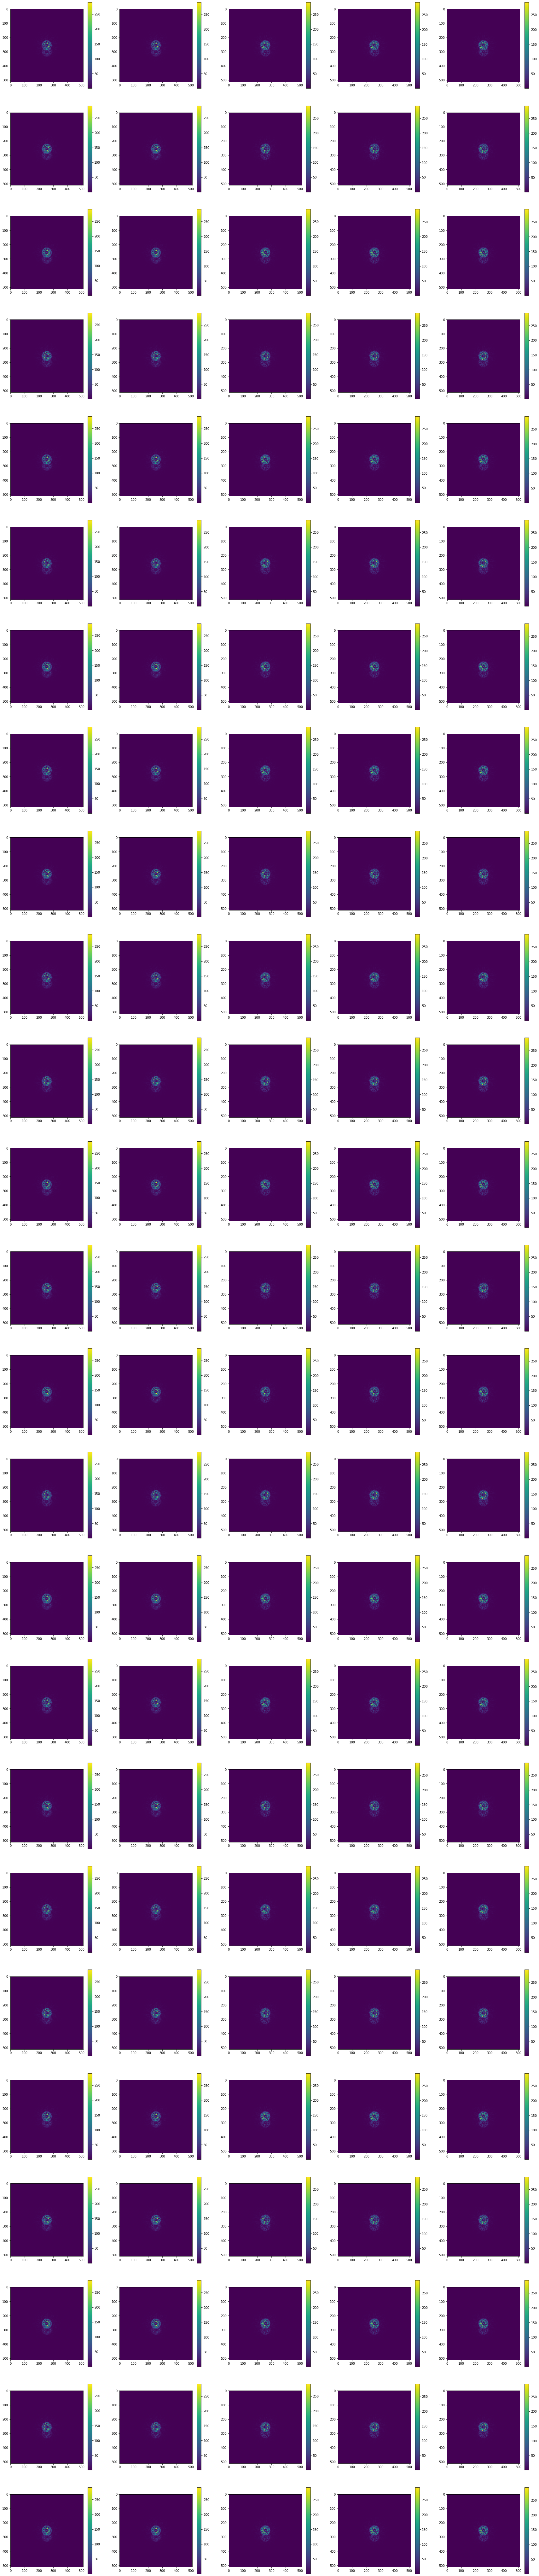

In [121]:
plt.figure(figsize=(30,150))

idx = 0
for i in range(5):
    for j in range(5):
        for k in range(5):
            idx += 1
            plt.subplot(25, 5, idx)
            plt.imshow(data[i][j][k])
            plt.colorbar()

(178.94049187875083, 178.94104374115764)

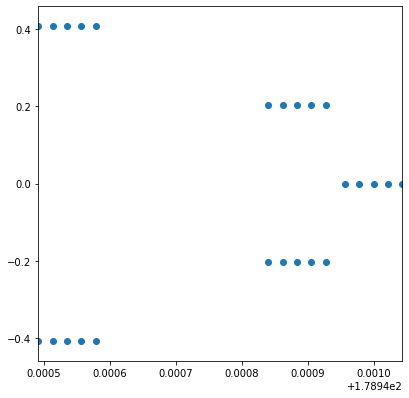

In [78]:
a = min(Xs)
b = max(Xs)
plt.figure(figsize=(30,30))
plt.subplot(4, 4, i+1)
plt.scatter(Xs, Ys)
plt.xlim(a,b)